In [1]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = (5, 5)
import warnings  # Hide all warnings here
warnings.filterwarnings("ignore")
import mne
mne.utils.set_log_level('error')
import local
from models.preprocessing import utils

#### Setup
Configuration and files selection

In [271]:
ext_in = ".vhdr"; ext_out = ".raw.fif.gz"
con_multi = {'trial': {'begin':'Stim/S  9','end':'Stim/S 10'},
              'stimulus': {'begin':'Stim/S 14','end':'Stim/S 15'},
              'blocks': {'VR':{'begin':'Stim/S102','end':'Stim/S104','stimuli':{'visual/0':'Stim/S 20','visual/45':'Stim/S 21','visual/90':'Stim/S 22','visual/135':'Stim/S 23'}},'VL':{'begin':'Stim/S108','end':'Stim/S110','stimuli':{'visual/0':'Stim/S 20','visual/45':'Stim/S 21','visual/90':'Stim/S 22','visual/135':'Stim/S 23'}},
                        'AL':{'begin':'Stim/S105','end':'Stim/S107','stimuli':{'audio/0':'Stim/S 16','audio/45':'Stim/S 17','audio/90':'Stim/S 18','audio/135':'Stim/S 19'}},'AR':{'begin':'Stim/S111','end':'Stim/S113','stimuli':{'audio/0':'Stim/S 16','audio/45':'Stim/S 17','audio/90':'Stim/S 18','audio/135':'Stim/S 19'}}},
              'responses': {'right/left':'Stim/S 60','right/down':'Stim/S 61','right/right':'Stim/S 62','right/up':'Stim/S 63',
                          'left/left':'Stim/S 64','left/down':'Stim/S 65','left/right':'Stim/S 66','left/up':'Stim/S 67',},
              'feedback': {'positive': 'Stim/S 50','negative':'Stim/S 52','neutral':'Stim/S 54'},
              'triggers': ['Stim/S 14'],
              'ignore': []
}
# Sample config - just change the 11 to the Nona code for stimulus onset
cond_multi = {'blocks':{'XX':{'stimuli':{'xy':'Stim/S 11'}}}}
conditions = [con_multi]
tstart = 0#40*60. # avoid tACS
d = "../../data/reinhartlab/multimodal/"
box = utils.select_dataset(d,ext_in,ext_out,single=True,show_all=False); box

#### Load and rereference data
The first step loads the Brainvision EEG file, adds a second/implicit Mastoid reference (if not already exisiting) and rereferences the data to the TP9/TP10 average.

In [300]:
#raws = [d+f+ext_in for f in utils.get_selection(box,fragments=False)]
raws = [utils.get_raw(d+f+ext_in) for f in utils.get_selection(box,fragments=True)]
raw = mne.concatenate_raws(raws)
evts,eids = mne.events_from_annotations(raw)

#### Find and fix bad channels
Bad channel detection is currently manual. The code below will plot several (time-averaged) topomaps for the ERP. Corrupt channels should show up as high-intensity spots across all topomaps. The variable 'bads' should be a list with the names of the channels to be interpolated.

In [301]:
stimuli = [eids[v] for c in conditions for b in c['blocks'].values() for v in b['stimuli'].values()]
evoked = mne.epochs.Epochs(raw,evts,stimuli,tmin=0,tmax=2).average()

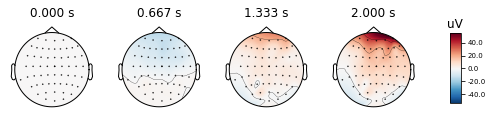

In [302]:
mne.evoked.plot_evoked_topomap(evoked);

In [306]:
bads = ['PO3','F6']
r = utils.fix_channels(raw.copy(),bads)

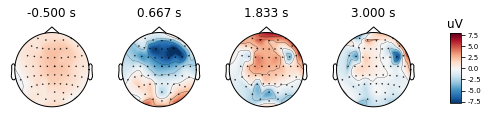

In [307]:
evoked = mne.epochs.Epochs(r.copy().crop(tmin=tstart),evts,stimuli,tmin=-.5,tmax=3).average()
mne.evoked.plot_evoked_topomap(evoked,average=.5);

In [295]:
raw=r

#### Apply ICA and remove EOG components
The following step uses ICA to decompose the time series of EEG channels, finds and removes components that are strongly correlated to EOG channel activity, and recomposes the data into channels.

In [303]:
raw,ica = utils.ica_cleanup(raw,components=20,tmin=tstart)

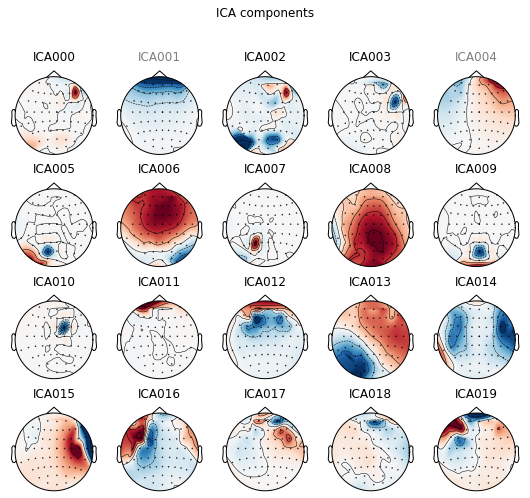

In [304]:
ica.plot_components();

In [45]:
ica.exclude += []
raw = ica.apply(raw)

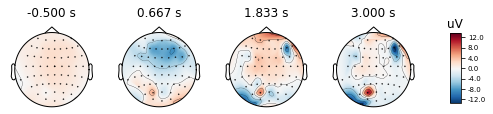

In [305]:
evoked = mne.epochs.Epochs(raw.copy().crop(tmin=tstart),evts,stimuli,tmin=-.5,tmax=3).average()
mne.evoked.plot_evoked_topomap(evoked,average=.5);

#### Save results
The preprocessed data can now be stored in a compressed MNE file format, in order to be used in subsequent analyses.

In [299]:
raw.save(raw.filenames[0][:-4]+'.raw.fif.gz',overwrite=True)
ica.save(raw.filenames[0][:-4]+'-ica.fif.gz');